# *Fake news*


## Comparación del poder predictivo de modelos de machine learning en la capacidad para detectar noticias falsas


<br>
La masificación del uso de internet ha cambiado la forma en la que vivimos para siempre. Nuestro modelo de consumo gira en torno al *smartphone; *desde la cesta de la compra hasta incluso ligar, la digitalización ha supuesto un gran avance en la calidad de vida de muchas personas. Sin embargo, el uso de internet es un arma de doble filo: la difusión de bulos amenaza a la estabilidad democrática de los países occidentales. Desde Rusia y China, o incluso desde nuestros propios Gobiernos, el uso de las llamadas *fake news *tiene una intencionalidad clara: servir a determinados colectivos sociales con intereses politicos y económicos diversos. Para detectar y eliminar estas noticias podemos hacer uso de la vasta cantidad de modelos predictivos de machine learning. Buscamos ser capaces de predecir con alta sensibilidad y especificidad cuales son fake news y cuales no lo son.


### Metodologia


> 
> * 
>   Preparación de un dataset con clases balanceadas a partir de dos dataset previos, fake y real, conteniendo varias decenas de miles de noticias falsas y verdaderas, respectivamente.
>   
>   
>   
> * 
>   Filtrado de variables. Vamos a combinar dos métodos de selección de variables: visualizaremos si existe una mayor proporción de fake news en determinadas categorias y, tras la aplicación del método *bag of words* seleccionaremos aquellas variables que tengan un valor del estadístico Chi2 más altas.
>   
>   
>   
> * 
>   Metodologia *bag of words*: es un muy conocido e intuitivo procedimiento de vectorización de texto usado en modelos Natural Language Processing (NLP). Brevemente, consiste en crear tantas variables como palabras distintas contiene un determinado texto, y asignar un número (1,2,3, etc) en función del número de veces que aparece esa palabra en un documento.
>   
>   
>   
> * 
>   Aplicación de varios modelos ML: Gradient Boosting, Regresion Logistica, Random Forest, SVM (lineal). La selección del mejor metodo se hará por medio de *held-out* dataset y comparacion del accuracy (porcentaje de noticias correctamente clasificadas como falsas y no falsas).
>   
>   
>   
> 
> 
> 




## 1. Data preparation

<br>

Para poder manejar el análisis cuajar la memoria de la maquina, voy elegir un subset de observaciones de los dataset fake y no fake en el que tendremos la misma cantidad de observaciones de cada clase

<br>

Importamos las librerías:



In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors


#nlp functions

import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


#other

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramonsotogarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ramonsotogarcia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Importamos los dos dataset y los procesamos:

In [2]:
#importamos y concatenamos el dataset en uno solo

df_fake = pd.read_csv("/Users/ramonsotogarcia/Desktop/Data/Fake news/Fake.csv", header = 0)
df_fake = df_fake.sample(frac = 0.05, random_state=123)
df_real = pd.read_csv("/Users/ramonsotogarcia/Desktop/Data/Fake news/True.csv", header = 0)
df_real = df_real.sample(frac = 0.05, random_state=123)

#fijarse que tomamos el 20% de los datos de arriba, para que os hagais una idea del tamanyo resultante si trabajo con el dataset completo


df_fake["Fake"] = [1 for i in range(df_fake.shape[0])]  #anyadimos la nueva variable objetivo
df_real["Fake"] = [0 for i in range(df_real.shape[0])]

df = pd.concat([df_fake, df_real], axis = 0) #unimos los dos df

df = df.sample(frac = 1)  #barajamos los datos

df = df.rename(columns = {"title":"titulo", "text":"texto", "subject":"categoria"}) #renombramos las columnas (por comodidad)

In [28]:
df.dtypes

titulo               object
texto                object
categoria            object
Fake                  int64
Date         datetime64[ns]
Month                 int64
All                  object
dtype: object

- Convertimos a date time la columna **date**:

In [ ]:
df["Date"] = pd.to_datetime(df["date"])

df.drop(columns = "date", inplace = True)

#add the variable Month

df["Month"] = df["Date"].dt.month  

Nuestro dataframe contiene la noticia en cada fila, y como variables tenemos tanto el titulo como el cuerpo de la misma. Asimismo tenemos la categoria y la columa que yo he creado en la que he puesto la *label* que servira para entrenar algoritmos de clasificacion.

In [20]:
#definimos una clase que sera util mas adelante:

class news:
    def __init__(self, corpus, fake):
        self.corpus = corpus
        self.fake = fake

In [21]:
df["All"] = df["titulo"] + " " + df["texto"]  #unimos el corpus de la noticia y el titulo, dejando un espacio en medio


In [25]:
#los ponemos en una lista

news_list = []

for i in range(df.shape[0]):
    news_list.append(news(df.iloc[i, 6], df.iloc[i,3]))

In [26]:
#el objeto 0 de la lista es la primera noticia del dataframe

print(news_list[0].corpus)

print(news_list[0].fake)

WOW! TREY GOWDY On Harry Reid’s Attack On Jim Comey: “I Didn’t Know Mormons Used Drugs” [Video]  
1


In [24]:
#separamos la lista para hacer el model training posterior

y = [x.fake for x in news_list]  

x = [x.corpus for x in news_list]




### <br>

## Exploratory data analysis

<br>

Cantidad de noticias falsas vs no falsas<br>



In [19]:
df.groupby( by = "Fake").count()["titulo"]

Fake
0    1071
1    1174
Name: titulo, dtype: int64

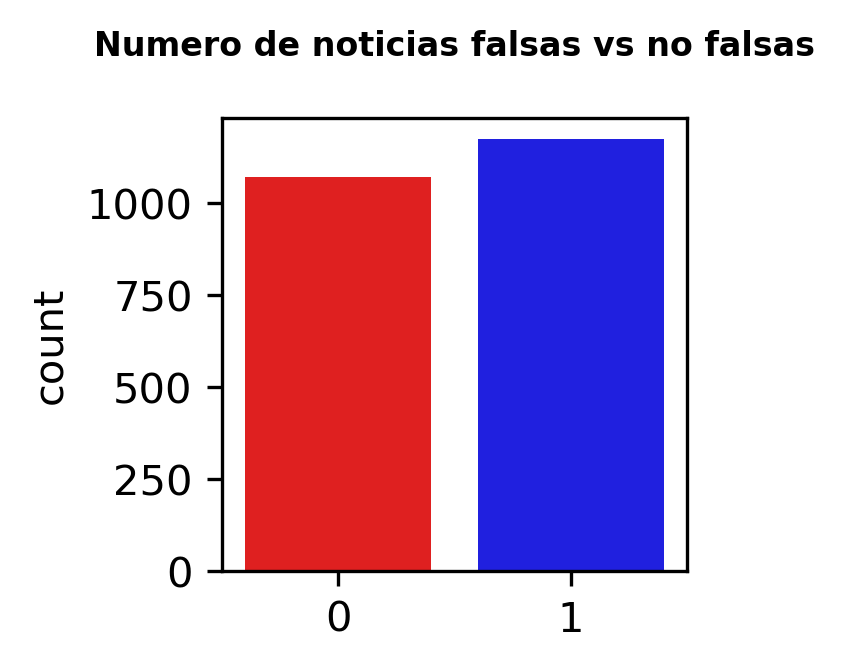

In [20]:
plt.figure(figsize = (2,2), dpi = 300)

sns.countplot(data = df, x = "Fake", palette = ["red", "blue"])
plt.title("Numero de noticias falsas vs no falsas", fontweight = "bold", fontsize = 8, pad=15)
plt.xlabel("")
plt.show()

Podría ser interesante ver si en algun mes en particular existe una mayor proporción de noticias falsas:

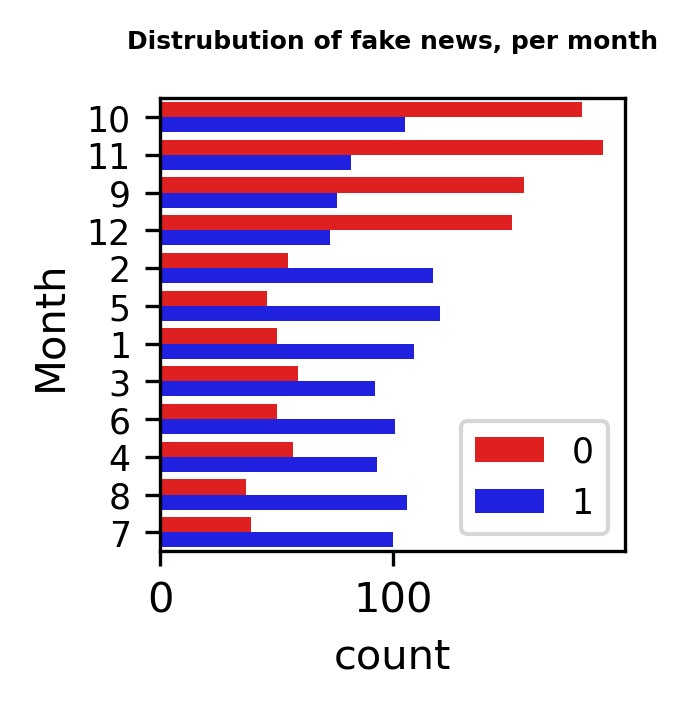

In [27]:
#visualise if there is a different distribution of fake/real news per month

plt.figure(figsize = (2,2), dpi = 300)

sns.countplot(data = df, y = "Month", hue = "Fake", order = df["Month"].value_counts().index, palette = ["red", "blue"])
plt.yticks(fontsize = "small")
plt.title("Distrubution of fake news, per month", fontsize = 6, fontweight = "bold", pad = 12)
plt.legend(fontsize = "small")
plt.show()

It seems in the first semester there is a much higher ratio of fake/real news. The last few months of the year it is the other way round.

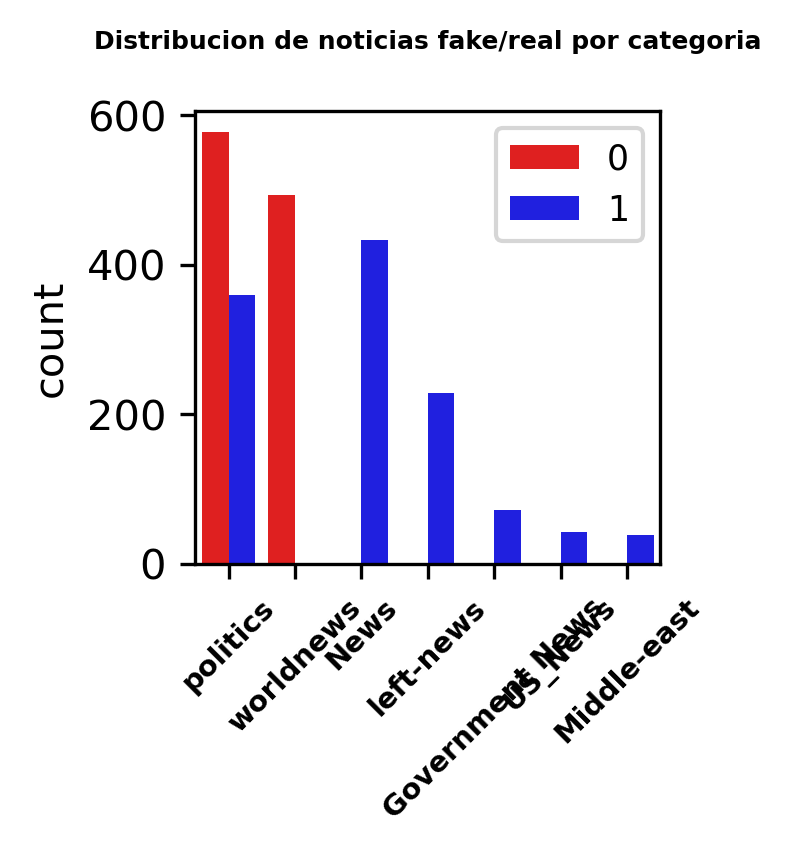

In [21]:
df.loc[df["categoria"] == "politicsNews", "categoria"] = "politics" 

plt.figure(figsize = (2,2), dpi = 300)

sns.countplot(data = df, x = "categoria", hue = "Fake", palette = ["red", "blue"], order = df["categoria"].value_counts().index)
plt.xticks(rotation = 45, fontsize = "x-small", fontweight = "bold")
plt.legend(fontsize = "small")
plt.title("Distribucion de noticias fake/real por categoria", fontsize= 6, fontweight = "bold", pad = 15)
plt.xlabel("")
plt.show()

Vemos por ejemplo que todas las categorías que están relacionadas con noticias del Gobierno o de Oriente Medio son falsas, lo que indica que la variable *Categoría* podría tener poder predictivo para discernir entre las fake news y las que no lo son. Como esta variable es categórica, tendremos que usar el llamado "one hot encoding" para convertir esta variable a *dummy*. 

### <br>

## Bag of words: conversión de texto a vectores numéricos

<br>

- El objetivo es poder usar las palabras dentro del titulo de la noticia para poder predecir si esta es fake o no. Tambien podriamos usar el cuerpo de la noticia, pero la matriz numerica resultado del proceso de vectorización seria tan grande que cuajaria la memoria RAM de mi maquina. (Esto va en linea con lo que os comente, el volumen de datos es tan grande que es obligatorio trabajar con Spark sobre un data lake).

<br>




### **Bag of Words**

In [22]:
#definimos la funcion que va a preprocesar el corpus de la noticia

def preprocess_text(text):
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')  #aqui toquenizamos el texto, eligiendo solo los characteres alfanumericos
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer() #aqui convertimos a diccionario y convertimos a minusculas
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords  #eliminamos las palabras mas comunes en ingles
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    return keywords


#esta funcion se la pasamos a TfIdfVectoriser:

x_matrix = TfidfVectorizer(analyzer = preprocess_text).fit_transform(x)  #con esta funcion transformamos las palabras a vectores numericos usando el metodo "bag of words"

x = pd.DataFrame.sparse.from_spmatrix(x_matrix)




Una breve explicacion de lo que sucede en la celda anterior: 

- Primero extraemos los ***tokens*** del corpus de la noticia (en este caso, tanto el titulo como el cuerpo). Los tokens son las palabras unicas del texto, las que vamos a usar para convertirlas a una matriz numerica.

- Segundo **convertimos a diccionario**. Esto significa que si tenemos dos palabras conjugadas del mismo verbo, por ejemplo "juagaba y jugando", ambas palabras se convertiran al infinitivo del verbo *jugar*.

- Tercero: convertimos a **minisculas**.

- Cuarto: eliminamos las ***stopwords***. Estas son las palabras del ingles que no van a suponer una ventaja respecto al poder predictivo de los modelos. Podemos imaginar como palabras como "el, la, y, ante, cabe, con, etc" son palabras que se repiten tanto que no serviran para la diferenciacion de las clases fake o no fake.

- Quinto: Aplicacion del metodo ***Bag of words***. Este procedimiento convierte una cadena de texto a una matriz numerica en la que cada fila es un vector que tiene tantas dimiensiones como palabras unicas existe en el texto. Las frecuencias de cada palabra en cada vector se normalizan. El resultado es una matriz numerica muy grande, como vemos en la celda abajo. Hemos creado 52261 variables a partir de palabras unicas del texto, y solo hemos tomado el 20% de todas las observaciones iniciales! Como os comentaba durante la videollamada, este tipo de procesos implica un volumen de datos muy grande, lo cual hace necesario el uso de *data lakes* como GCS o Amazon S3.

In [13]:
x.head(5)  #resultado del metodo Bag of Words

,0,1,2,3,4,5,6,7,8,9,...,52252,52253,52254,52255,52256,52257,52258,52259,52260,52261
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vemos como hemos pasado de un listado de noticias a una matriz numerica. Esta la usaremos para construir nuestros modelos de machine learning.

## 2. Selección de variables: metodo *Univariate feature selection* con el estadistico chi2

<br>

Ahora que ya hemos creado el dataframe final con el que vamos a trabajar, vamos poner en un ranking todas las variables en orden ascendente del resultado de un test Chi2 contra la variable objetivo binaria *Fake*. Es importante recordar que los test de hipótesis están fuertemente afectados por el tamaño muestral, de forma que cuanto mayor es esto último, menor sera el p value resultante del test. Esto quiere decir que el error tipo 2 (falsos negativos) sera practicamente inexistente, pero muy probablemente las diferencias detectadas sean insignificantes a pesar de tener un p-value muy bajo.



In [14]:
from sklearn.feature_selection import chi2, SelectKBest

k_best = SelectKBest(chi2, k = "all").fit(x, y) 

chi_results = pd.DataFrame(data = {"Features":x.columns, "Chi2 p_value": k_best.pvalues_})

chi_results = chi_results.sort_values(by = "Chi2 p_value", ascending = True)


In [15]:
print("Hay un total de: ", round(((chi_results.loc[chi_results["Chi2 p_value"] < 0.001].shape[0] / x.shape[1])* 100), 2),"% de variables significativas segun el Chi 2 test para un alpha = 0.001")
print("Hay un total de: ", round(((chi_results.loc[chi_results["Chi2 p_value"] < 0.01].shape[0] / x.shape[1])* 100), 2),"% de variables significativas segun el Chi 2 test para un alpha = 0.01")
print("Hay un total de: ", round(((chi_results.loc[chi_results["Chi2 p_value"] < 0.05].shape[0] / x.shape[1])* 100), 2),"% de variables significativas segun el Chi 2 test para un alpha = 0.05")




Hay un total de:  0.35 % de variables significativas segun el Chi 2 test para un alpha = 0.001
Hay un total de:  0.83 % de variables significativas segun el Chi 2 test para un alpha = 0.01
Hay un total de:  1.67 % de variables significativas segun el Chi 2 test para un alpha = 0.05


En este momento podemos decidir cuan conservadores queremos ser. Con un alpha muy bajo tendremos menos falsos positivos, pero dejaremos falsos negativos sin seleccionar, por no hablar de las posibles interacciones que haya entre las variables que se queden fuera del análisis. Al contrario, con un gran valor de alpha es posible que tengamos menos falsos negativos, pero tendremos mas falsos positivos. 



## Machine Learning



Vamos a seleccionar las variables que tienen un p-value menor a 0.05 y realizar modelos predictivos. La elección del mejor modelo se realizara comparando el accuracy o el porcentaje de noticias correctamente clasificadas como falsas o no falsas.

- Para ello, partimos el dataset en train y validation set, usando este ultimo para validar el rendimiento del modelo. Por ultimo, usaremos el test dataset (separado inicialmente antes de la particion train/validation set) una vez elegido el mejor modelo para evaluar su rendimiento en datos independientes.




<br>

Selección de variables y preparacion previo al ML

In [31]:
from sklearn.model_selection import train_test_split

df_p1 = chi_results.loc[chi_results["Chi2 p_value"] < 0.05, "Features"].values  #lo guardamos como un array
x_final = x.loc[:, df_p1] #seleccionamos estas variables del dataframe original
x_final["Fake"] = y

x_final.reset_index(inplace = True)
x_final.sample(frac = 1)  #barajamos los datos


x = x_final.drop(columns= "Fake")  #variables predictoras y objetivo finales
y = x_final["Fake"]

#original split

#el x_test_original lo usaremos para evaluar el rendimiento del modelo en datos independientes

x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(x, y, random_state=123, test_size=0.2, stratify = y)

df_train = pd.concat([x_train_original, y_train_original], axis = 1)  #necesario para hacer el split sobre el train data

df_train.reset_index(inplace = True)

x_model = df_train.drop(columns = ["Fake"])
y_model = df_train["Fake"]

#volvemos a partir del train dataset para evaluar nuestros modelos

#ahora obtenemos el training set, que usaremos para entrenar los modelos, 
#y el validation set, que usaremos para comparar el rendimiento entre todos los modelos

x_train, x_test, y_train, y_test = train_test_split(x_model, y_model, random_state=123, test_size=0.2, stratify = y_model)



### Regresion Logistica<br>



In [32]:
lr_model = LogisticRegression().fit(x_train, y_train)

preds = lr_model.predict(x_test)

lr_acc = accuracy_score(y_test, preds)



### Linear SVM



In [33]:

svm_model = LinearSVC(C=1.0).fit(x_train, y_train)

preds = svm_model.predict(x_test)

svm_acc = accuracy_score(y_test, preds)




### Random Forest Classifier



In [34]:
rf = RandomForestClassifier(min_samples_leaf = 30, n_estimators = 500, max_features = "sqrt").fit(x_train, y_train)

preds = rf.predict(x_test)

rf_acc = accuracy_score(y_test, preds)


### Gradient Boosting



In [35]:
gb =  GradientBoostingClassifier(max_depth=2, n_estimators = 300, learning_rate = 0.1).fit(x_train, y_train)

preds = gb.predict(x_test)

gb_acc = accuracy_score(y_test, preds)


#### Comparacion de rendimiento entre modelos ML

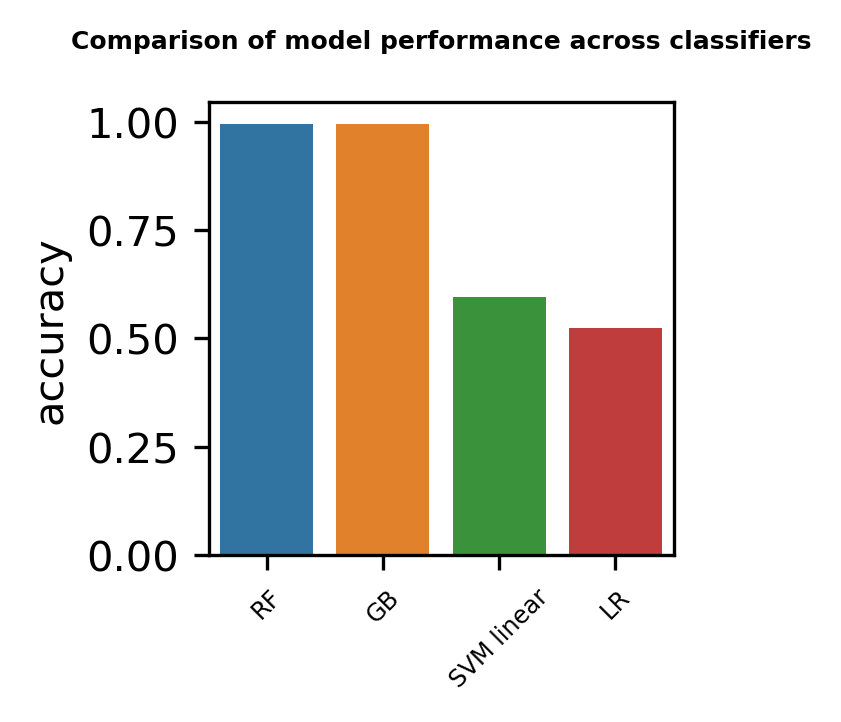

In [36]:
#visualizacion de los resultados de ML


results_df = pd.DataFrame(data = dict(Model = ["LR", "SVM linear", "RF", "GB"], accuracy = [lr_acc, svm_acc, rf_acc, gb_acc]))

results_df.sort_values(by = "accuracy", ascending = False, inplace = True)

plt.figure(figsize = (2,2), dpi= 300)

sns.barplot(data = results_df, x = "Model", y = "accuracy")
plt.title("Comparison of model performance across classifiers", fontsize = 6, fontweight = "bold", pad = 13)
plt.xticks(rotation = 45, fontsize = "xx-small")
plt.xlabel("")
plt.show()



Parece que los metodos no parametricos son los que mejor resultado proporcionan en cuanto a la correcta clasificacion de noticias. Aparentemente las clases no pueden ser separadas con un metodo lineal como la regresion logistica o el SVM con kernel lineal, lo cual es de esperar en datos complejos como los analisis de texto. Hay que indicar que el random forest aqui encontrado como el mejor modelo debe ser validado en posteriores datasets. Tambien es necesario mencionar que, por motivos de eficiencia computacional, hemos entrenado el modelo con un subset de las noticias del dataset y hemos elegido una fraccion de las variables tras la conversion a matriz numerica.

### Visualizar la matriz de confusion

- Visualizar la matriz de confusion proporciona una inspeccion visual sobre el rendimiento del clasificador en terminos de sensibilidad y especificidad. Brevemente, cuanto mayor es el numero de observaciones en la diagonal de la matriz, mas sensible y mas especifico es el modelo.

#### Random Forest (mejor modelo)

In [37]:
#model fit

rf = RandomForestClassifier(min_samples_leaf = 30, n_estimators = 500, max_features = "sqrt").fit(x_train, y_train)

preds = rf.predict(x_test) #predicciones en el validation set

<Figure size 600x600 with 0 Axes>

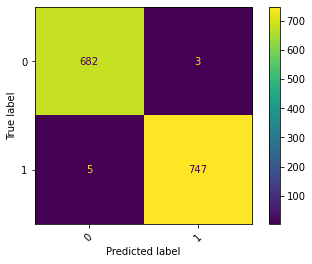

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

c_matrix = confusion_matrix(y_true = y_test, y_pred = preds, labels = rf.classes_)

plt.figure(figsize = (2,2), dpi = 300)

ConfusionMatrixDisplay(c_matrix).plot()
plt.xticks(rotation = 45)
plt.show()

#### Resultados

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_test, y_pred = preds, digits = 3))

              precision    recall  f1-score   support

           0      0.993     0.996     0.994       685
           1      0.996     0.993     0.995       752

    accuracy                          0.994      1437
   macro avg      0.994     0.994     0.994      1437
weighted avg      0.994     0.994     0.994      1437



La **precision** se define como la proporcion de verdaderos positivos (en este caso, las noticias que son fake) dentro de todas las noticias declaradas como positivas. En este caso, de cada 100 noticias que la regresion logistica considera que son falsas, 99.6 de ellas son realmente falsas.

El **recall** es un sinonimo de sensibilidad. Es decir, la proporcion de noticias falsas que el clasificador correctamente clasifica como falsas.

El **f1-score** es una metrica que evalua como de bueno es el clasificador. Cuanto mayores sean precision y recall, mas cercado es este valor a 1 (el valor maximo)

### Evaluacion del rendimiento del modelo en el test data

Ahora vamos a usar el 20% de los datos restantes que no han sido usados para entrenar el modelo. El objetivo es testar la eficacia del algoritmo random forest en datos que no han sido "vistos" por el modelo. Esto nos va a ayudar a evaluar el rendimiento del modelo en datos independientes y saber si hemos incurrido en *overfitting*, lo cual indicaria que el modelo se comporta muy bien en datos *training* pero no puede generalizar correctamente a futuros datos. 

In [40]:
#elegimos el mejor modelo en cuanto a accuracy

#model fit

rf = RandomForestClassifier(min_samples_leaf = 30, n_estimators = 500, max_features = "sqrt").fit(x_train_original, y_train_original)

preds = rf.predict(x_test_original) #predicciones en el test set

<Figure size 600x600 with 0 Axes>

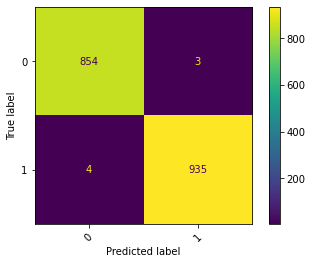

In [41]:
c_matrix = confusion_matrix(y_true = y_test_original, y_pred = preds, labels = rf.classes_)

plt.figure(figsize = (2,2), dpi = 300)

ConfusionMatrixDisplay(c_matrix).plot()
plt.xticks(rotation = 45)
plt.show()

 - Vemos que tenemos valores muy altos en la diagonal de la matriz de confusion y muy pocos en los componentes de la off-diagonal. El modelo clasifica correctamente tanto noticias falsas como noticas no falsas lo que indica que el rendimiento del modelo es muy bueno en el test data. A falta de una posterior validacion con futuros datos, el random forest entrenado aqui es un buen modelo para detectar noticias falsas.

In [43]:
print(classification_report(y_true = y_test_original, y_pred = preds, digits = 3))

              precision    recall  f1-score   support

           0      0.995     0.996     0.996       857
           1      0.997     0.996     0.996       939

    accuracy                          0.996      1796
   macro avg      0.996     0.996     0.996      1796
weighted avg      0.996     0.996     0.996      1796

